#### Steps to setup Openbb SDK in Jupyter notebook

1. Check conda version

    $ conda --version 

2. Update conda recommended

    $ conda update -n base -c conda-forge conda

3. Setup and activate the `meta-labell` environment

    $ conda env create --file=environment.yaml

    $ conda activate meta-labell    

4. Install openbb sdk
    
    $ pip install "openbb" --no-cache-dir              

### Introduction 
This notebook studies fundamentals and price signals of common cryptocurrencies using the OpenBB SDK. We consider the universe of cryptos with at least a $ 100 Million USD market capitalization on Coinmarketcap.  

### Data
We use the OpenBB SDK to download the data from the OpenBB API. The data is stored in a local database. The data is updated daily. 

### Methods 
We begin with a simple forecasting model such as AutoArima and explore intra-day changes in volatility and prices. As part of our token selection process, we also use fundamental knowledge about each cryptocurrency, especially for newer tokens such as the number of developers on each project's Github, and the frequency of commits. 

### Acknowledgements 
I extensively used Sean Taylor's code on forecasting oil prices as a reference for this notebook. For additional details, visit his repo on github:  https://github.com/seanjtaylor/gas-price-forecast 

In [17]:
%load_ext lineapy

The lineapy extension is already loaded. To reload it, use:
  %reload_ext lineapy


In [18]:
import numpy as np
import pandas as pd
from openbb_terminal.sdk import openbb
from statsforecast.models import AutoARIMA
import requests
import re
import altair as alt
from scipy.linalg import svd
import lineapy

from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import acf
%matplotlib inline

# Turn off warnings and messages 
import warnings
warnings.filterwarnings('ignore')

In [19]:
# Show trending coins
openbb.crypto.disc.trending()

START                                                                           
{"INPUT": {"chart": "False"}, "VIRTUAL_PATH": "crypto.disc.trending", "CHART":  
false}                                                                          
START                                                                           
END                                                                             
END                                                                             


,Symbol,Name,market_cap Cap Rank
0,bella-protocol,Bella Protocol,469
1,bonk,Bonk,931
2,trust-wallet-token,Trust Wallet,100
3,bitcoin,Bitcoin,1
4,gala,GALA,93
5,qanplatform,QANplatform,304
6,edu-coin,Open Campus,271


In [20]:
btc_df = openbb.crypto.load(symbol="btc",to_symbol="usd",start_date="2019-01-01",source="YahooFinance")
eth_df = openbb.crypto.load(symbol="eth",to_symbol="usd",start_date="2019-01-01",source="YahooFinance")

# Combine btc and eth dataframes and save under /data. Append current date to the filename. 
# Add a new column identifying which coin the row belongs to. 
btc_df['coin'] = 'btc'
eth_df['coin'] = 'eth'
btc_eth_df = pd.concat([btc_df,eth_df],axis=0)

btc_eth_df.tail(5)

START                                                                           
{"INPUT": {"start_date": "2019-01-01", "interval": "1440", "exchange":          
"binance", "to_symbol": "usd", "end_date": "None", "source": "YahooFinance",    
"symbol": "btc", "chart": "False"}, "VIRTUAL_PATH": "crypto.load", "CHART":     
false}                                                                          
END                                                                             
START                                                                           
{"INPUT": {"start_date": "2019-01-01", "interval": "1440", "exchange":          
"binance", "to_symbol": "usd", "end_date": "None", "source": "YahooFinance",    
"symbol": "eth", "chart": "False"}, "VIRTUAL_PATH": "crypto.load", "CHART":     
false}                                                                          
END                                                                             


,Open,High,Low,Close,Adj Close,Volume,coin
date,,,,,,,
2023-09-07,1632.262817,1657.303711,1623.220459,1647.598267,1647.598267,4907290296,eth
2023-09-08,1647.807617,1657.136353,1617.796509,1636.137817,1636.137817,4598495496,eth
2023-09-09,1636.050415,1636.870728,1629.660889,1635.162354,1635.162354,2081625742,eth
2023-09-10,1635.211670,1635.433105,1604.040527,1616.828857,1616.828857,4339499949,eth
2023-09-11,1616.769775,1618.305786,1533.426758,1551.637695,1551.637695,7693700923,eth


In [21]:
# Save btc_eth_df as a csv file under /data
btc_eth_df.to_csv('data/btc_eth_df.csv')

In [22]:
lineapy.save(btc_eth_df, "data/btc_eth_df")

LineaArtifact(name='data/btc_eth_df', _version=5)

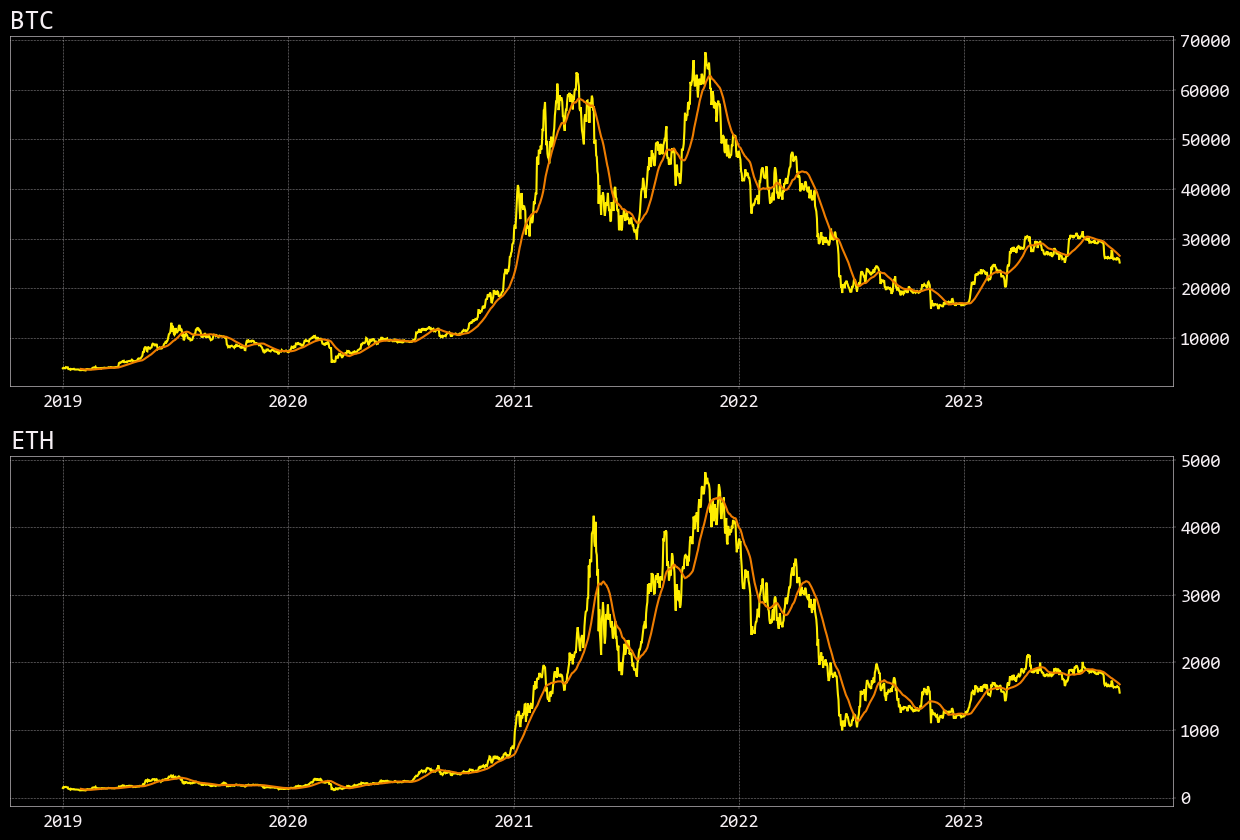

In [23]:
# Plot the Adj Close price overtime for BTC and ETH. 
# Use two separate subplots for BTC and ETH.
import matplotlib.pyplot as plt
import pandas as pd

# Calculate the 30-day moving average for BTC and ETH
btc_df['MA'] = btc_df['Adj Close'].rolling(window=30).mean()
eth_df['MA'] = eth_df['Adj Close'].rolling(window=30).mean()

# Create subplots for BTC and ETH
fig, axes = plt.subplots(2,1,figsize=(15,10))

# Plot the Adj Close price and the moving average for BTC
axes[0].plot(btc_df['Adj Close'])
axes[0].plot(btc_df['MA'])
axes[0].set_title('BTC')

# Plot the Adj Close price and the moving average for ETH
axes[1].plot(eth_df['Adj Close'])
axes[1].plot(eth_df['MA'])
axes[1].set_title('ETH')

# Show the plots
plt.show()

### Trend Analysis 
Using ACF plots for autocorrelation, test the hypothesis that there is no momentum in the price for each token. Explore the presence or lack of mean reversion in the prices. 

In [24]:
H = 13
CI = 80
width = 300
height = 250
cutoff_date = "2023-10-01"
plot_start_date = "2023-01-01"
plot_title = f"Forecasted Price (as of {cutoff_date})"

In [25]:
m_aa = AutoARIMA()
m_aa.fit(btc_df["Adj Close"].values)

AutoARIMA

In [26]:
raw_forecast = m_aa.predict(h=H, level=(CI,))
raw_forecast_exp = {key: np.exp(value) for key, value in raw_forecast.items()}

In [27]:
# Plot the bitcoin prices with the forecasts on the same plot 
btc_forecast = pd.DataFrame(raw_forecast)
btc_forecast["Date"] = pd.date_range(cutoff_date, periods=H, freq="M")

# Rename mean to mean_adj_close, Adj Close to adj_close
btc_forecast = btc_forecast.rename(columns={"mean": "mean_adj_close", "Adj Close": "adj_close"})

# Add forecasts to the original dataframe and plot 
btc_df = btc_df.append(btc_forecast, ignore_index=True)
btc_df.tail(20)

,Open,High,Low,Close,Adj Close,Volume,coin,MA,mean_adj_close,lo-80,hi-80,Date
1708,25814.957031,25858.375000,25589.988281,25779.982422,25779.982422,1.109474e+10,btc,27250.120703,NaN,NaN,NaN,NaT
1709,25783.931641,25953.015625,25404.359375,25753.236328,25753.236328,1.275271e+10,btc,27135.875977,NaN,NaN,NaN,NaT
1710,25748.312500,26409.302734,25608.201172,26240.195312,26240.195312,1.108831e+10,btc,27018.366081,NaN,NaN,NaN,NaT
1711,26245.208984,26414.005859,25677.480469,25905.654297,25905.654297,1.081736e+10,btc,26896.504753,NaN,NaN,NaN,NaT
1712,25905.425781,25921.976562,25810.494141,25895.677734,25895.677734,5.481314e+09,btc,26778.707617,NaN,NaN,NaN,NaT
1713,25895.210938,25978.130859,25640.261719,25832.226562,25832.226562,7.899553e+09,btc,26659.858008,NaN,NaN,NaN,NaT
1714,25831.714844,25883.947266,24930.296875,25162.654297,25162.654297,1.460001e+10,btc,26518.080990,NaN,NaN,NaN,NaT
1715,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,25162.654297,23816.777379,26508.531215,2023-10-31
1716,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,25162.654297,23259.296906,27066.011688,2023-11-30
1717,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,25162.654297,22831.527094,27493.781500,2023-12-31


In [28]:
# Save the btc file with forecasts to csv
btc_df.to_csv('data/btc_df_forecast.csv')

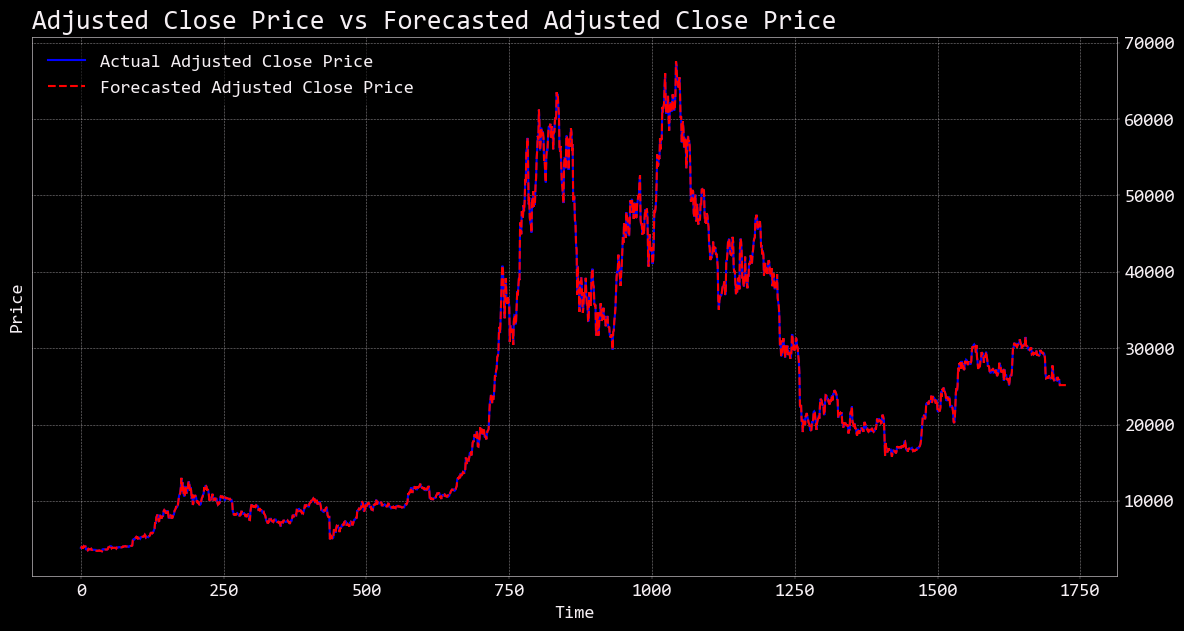

In [29]:
# Create a new column to hold the forecasted prices, filling missing values with the actual prices
btc_df['Forecasted_Adj_Close'] = btc_df['mean_adj_close'].fillna(btc_df['Adj Close'])

# Plotting the Adjusted Close price and Forecasted Adjusted Close price
plt.figure(figsize=(14, 7))
plt.plot(btc_df['Adj Close'], label='Actual Adjusted Close Price', color='blue')
plt.plot(btc_df['Forecasted_Adj_Close'], label='Forecasted Adjusted Close Price', linestyle='--', color='red')
plt.title('Adjusted Close Price vs Forecasted Adjusted Close Price')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

### References 
Sean Taylor. Gas Price Forecast. https://github.com/seanjtaylor/gas-price-forecast